In [1]:
import collections
import copy
import functools
import itertools

import numpy as np
from typing import List, Iterable, Any, Union, Optional, overload
import matplotlib.pyplot as plt
import sympy
import networkx as nx
from scipy.linalg import dft
from tqdm import notebook

In [2]:
import linear_regression as lr
import sparse_factorization as sf
import topology as topo

# Doubly stochastic hierarchically banded (DSHB) factorization algorithm

In [3]:
n = 43
n_sub = [32, 8, 3]
n_sub_facts = [[2,2,2,2,2], [2,2,2], [3]]
max_period = max(len(fact) for fact in n_sub_facts)

for sub, sub_facts in zip(n_sub, n_sub_facts):
    assert sub == np.prod(sub_facts)

In [4]:
def consensus(x):
    return np.linalg.norm(x - np.mean(x), ord=2)

In [236]:
def get_mse_sds(n_sub, n_sub_facts, seed=123):
    np.random.seed(seed)
    n = sum(n_sub)
    x = np.random.randn(n)
    full_list = sf.get_all_sds_matrices(n_sub, n_sub_facts)
    mse_list = []
    mse_list.append(consensus(x))
    accum_degree = [0]
    for A in full_list:
        x = A @ x
        mse_list.append(consensus(x))
        accum_degree.append(accum_degree[-1] + np.count_nonzero(A))
    return np.asarray(mse_list) / mse_list[0], accum_degree


In [237]:
def get_mse_dshb(n_sub, n_sub_facts, seed=123):
    np.random.seed(seed)
    n = sum(n_sub)
    x = np.random.randn(n)
    full_list = sf.get_all_dshb_matrices(n_sub, n_sub_facts)
    mse_list = []
    mse_list.append(consensus(x))
    accum_degree = [0]
    for A in full_list:
        x = A @ x
        mse_list.append(consensus(x))
        accum_degree.append(accum_degree[-1] + np.count_nonzero(A))
    return np.asarray(mse_list) / mse_list[0], accum_degree


In [238]:
def get_mse_rhb(n_sub, n_sub_facts, seed=123):
    np.random.seed(seed)
    n = sum(n_sub)
    x = np.random.randn(n)
    full_list = sf.get_all_rhb_matrices(n_sub, n_sub_facts)
    mse_list = []
    mse_list.append(consensus(x))
    accum_degree = [0]
    for A in full_list:
        x = A @ x
        mse_list.append(consensus(x))
        accum_degree.append(accum_degree[-1] + np.count_nonzero(A))
    return np.asarray(mse_list) / mse_list[0], accum_degree


In [239]:
def get_mse_exp(size, iters, seed=123):
    np.random.seed(seed)
    n=size
    x = np.random.randn(n)
    mse_list = []
    mse_list.append(consensus(x))
    accum_degree = [0]
    for i in range(iters):
        A = topo.dynamic_exp2(i, size=n)
        x = A @ x
        mse_list.append(consensus(x))
        accum_degree.append(accum_degree[-1] + np.count_nonzero(A) - n)
    return np.asarray(mse_list) / mse_list[0], accum_degree

In [240]:
def get_mes_hypercuboid(size, factors, iters, seed=123):
    np.random.seed(seed)
    x = np.random.randn(n)
    mse_list = []
    mse_list.append(consensus(x))
    accum_degree = [0]
    for i in range(iters):
        A = topo.dynamic_hypercuboid(i, factors=factors)
        x = A @ x
        mse_list.append(consensus(x))
        accum_degree.append(accum_degree[-1] + np.count_nonzero(A))
    return np.asarray(mse_list) / mse_list[0], accum_degree

In [241]:
def generate_test_case():
    # n_sub = [32, 6, 3] # 41
    # n_sub_facts = [[2,2,2,2,2], [3, 2], [3]]
    # yield n_sub, n_sub_facts

    n_sub = [32, 8, 2] # 42
    n_sub_facts = [[2,2,2,2,2], [2,2,2], [2]]
    yield n_sub, n_sub_facts
    
    n_sub = [32, 8, 3] # 43
    n_sub_facts = [[2,2,2,2,2], [2,2,2], [3]]
    yield n_sub, n_sub_facts
    
    # n_sub = [243, 8, 2] # 253
    # n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [2]]
    # yield n_sub, n_sub_facts
    
    n_sub = [243, 8, 3] # 254
    n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [3]]
    yield n_sub, n_sub_facts

    n_sub = [243, 9, 3] # 255
    n_sub_facts = [[3, 3, 3, 3, 3], [3, 3], [3]]
    yield n_sub, n_sub_facts

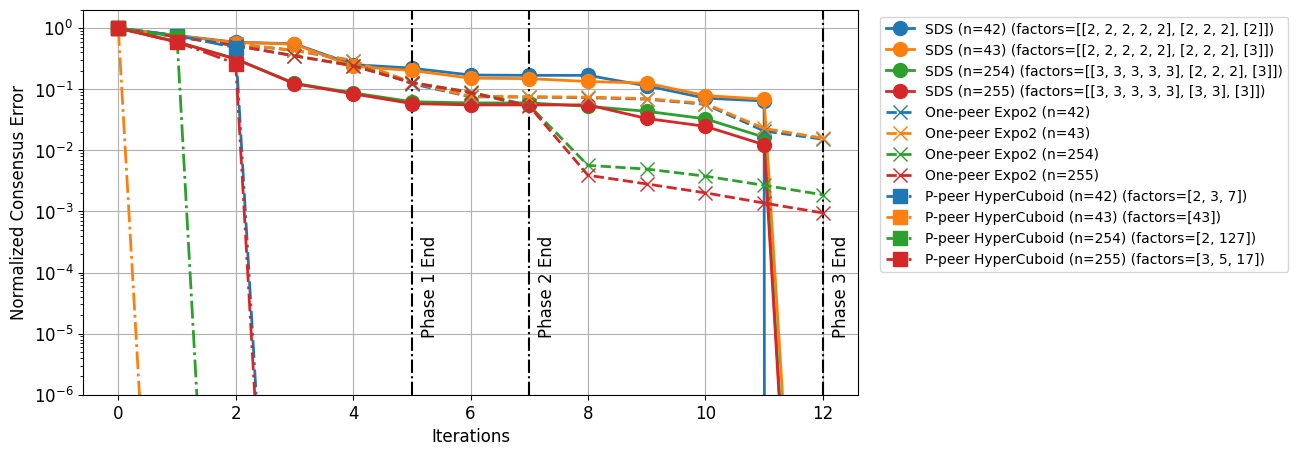

In [242]:
plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 
plt.rc('legend', fontsize=10)
# SDS
plot_phase=True
for n_sub, n_sub_facts in generate_test_case():
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    for sub, sub_facts in zip(n_sub, n_sub_facts):
        assert sub == np.prod(sub_facts)
    
    consensus_error, accum_degree = get_mse_sds(n_sub, n_sub_facts)
    plt.semilogy(consensus_error, label=f"SDS ({n=}) (factors={n_sub_facts})", marker="o", linewidth=2, markersize=10)
    if plot_phase:
        plt.axvline(max_period,  linestyle="-.", color="black")
        plt.text(max_period + 0.15, 1e-5, 'Phase 1 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period + len(n_sub) - 1,  linestyle="-.", color="black")
        plt.text(max_period+ len(n_sub) - 1 + 0.15, 1e-5, 'Phase 2 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period *2 + len(n_sub) -1,  linestyle="-.", color="black")
        plt.text(max_period *2 + len(n_sub) -1 + 0.15, 1e-5, 'Phase 3 End', fontsize=12, rotation="vertical")
        plot_phase = False

# Dyn_exp2
for i, n in enumerate([42, 43, 254, 255]):
    consensus_error, accum_degree = get_mse_exp(n, iters=12)
    plt.semilogy(consensus_error, '--', label=f"One-peer Expo2 ({n=})", marker="x", linewidth=2, markersize=10,
                 color=f"C{i}")


for i, (n, factors) in enumerate([
        # (41, [41]),
        (42, [2, 3, 7]), 
        (43, [43]),
        # (253, [11, 23]), 
        (254, [2, 127]), 
        (255, [3, 5, 17])
    ]):
    consensus_error, accum_degree = get_mes_hypercuboid(n, factors=factors, iters=12)
    plt.semilogy(consensus_error, '-.', label=f"P-peer HyperCuboid ({n=}) ({factors=})", marker="s", linewidth=2, markersize=10,
                 color=f"C{i}")


plt.ylim(1e-6, 2e0)
plt.xlabel("Iterations")
plt.ylabel("Normalized Consensus Error")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig('consensus.pdf',  format="pdf")
plt.show()

SDS (n=42) Comm: 948
SDS (n=43) Comm: 1004
SDS (n=254) Comm: 8076
SDS (n=255) Comm: 8190
One-peer Expo2  (n=42) Comm: 504
One-peer Expo2  (n=43) Comm: 516
One-peer Expo2  (n=254) Comm: 3048
One-peer Expo2  (n=255) Comm: 3060
P-peer HyperCuboid (n=42) Comm: 504
P-peer HyperCuboid (n=43) Comm: 1849
P-peer HyperCuboid (n=254) Comm: 32766
P-peer HyperCuboid (n=255) Comm: 6375


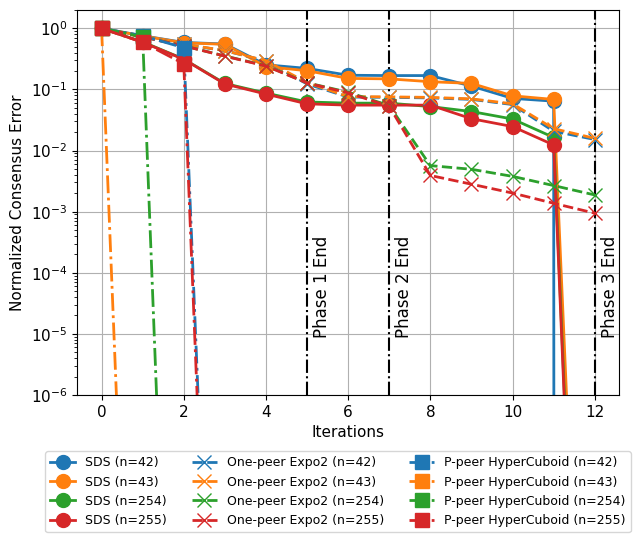

In [243]:
plt.figure(figsize=(7, 5))
plt.rc('font', size=11) 
plt.rc('legend', fontsize=9)
# SDS
plot_phase=True
for n_sub, n_sub_facts in generate_test_case():
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    for sub, sub_facts in zip(n_sub, n_sub_facts):
        assert sub == np.prod(sub_facts)
    
    consensus_error, accum_degree = get_mse_sds(n_sub, n_sub_facts)
    plt.semilogy(consensus_error, label=f"SDS ({n=})", marker="o", linewidth=2, markersize=10)
    print(f"SDS ({n=}) Comm: {accum_degree[-1]}")
    if plot_phase:
        plt.axvline(max_period,  linestyle="-.", color="black")
        plt.text(max_period + 0.15, 1e-5, 'Phase 1 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period + len(n_sub) - 1,  linestyle="-.", color="black")
        plt.text(max_period+ len(n_sub) - 1 + 0.15, 1e-5, 'Phase 2 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period *2 + len(n_sub) -1,  linestyle="-.", color="black")
        plt.text(max_period *2 + len(n_sub) -1 + 0.15, 1e-5, 'Phase 3 End', fontsize=12, rotation="vertical")
        plot_phase = False

# Dyn_exp2
for i, n in enumerate([42, 43, 254, 255]):
    consensus_error, accum_degree = get_mse_exp(n, iters=12)
    plt.semilogy(consensus_error, '--', label=f"One-peer Expo2 ({n=})", marker="x", linewidth=2, markersize=10,
                 color=f"C{i}")
    print(f"One-peer Expo2  ({n=}) Comm: {accum_degree[-1]}")

for i, (n, factors) in enumerate([
        # (41, [41]),
        (42, [2, 3, 7]), 
        (43, [43]),
        # (253, [11, 23]), 
        (254, [2, 127]), 
        (255, [3, 5, 17])
    ]):
    consensus_error, accum_degree = get_mes_hypercuboid(n, factors=factors, iters=12)
    plt.semilogy(consensus_error, '-.', label=f"P-peer HyperCuboid ({n=})", marker="s", linewidth=2, markersize=10,
                 color=f"C{i}")
    print(f"P-peer HyperCuboid ({n=}) Comm: {accum_degree[len(factors)]}")


plt.ylim(1e-6, 2e0)
plt.xlabel("Iterations")
plt.ylabel("Normalized Consensus Error")
plt.grid(True)
plt.legend(bbox_to_anchor=(-0.07, -0.13), loc='upper left', ncol=3)
plt.savefig('consensus.pdf',  format="pdf")
plt.show()

RHB (n=42) Comm: 888
RHB (n=43) Comm: 939
RHB (n=254) Comm: 7800
RHB (n=255) Comm: 7911
DSHB (n=255) Comm: 910
DSHB (n=255) Comm: 967
DSHB (n=255) Comm: 7828
DSHB (n=255) Comm: 7941


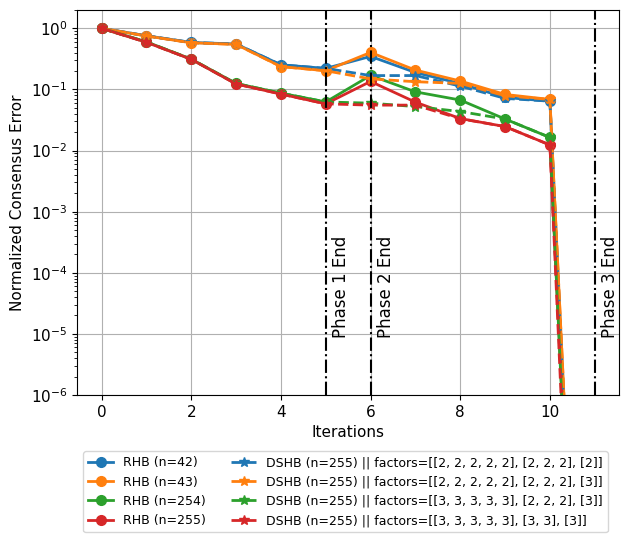

In [250]:
plt.figure(figsize=(7, 5))
plt.rc('font', size=11) 
plt.rc('legend', fontsize=9)
# RHB
plot_phase=True
for i, (n_sub, n_sub_facts) in enumerate(generate_test_case()):
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    for sub, sub_facts in zip(n_sub, n_sub_facts):
        assert sub == np.prod(sub_facts)
    
    consensus_error, accum_degree = get_mse_rhb(n_sub, n_sub_facts)
    plt.semilogy(consensus_error, label=f"RHB ({n=})", marker="o", linewidth=2, markersize=7, color=f"C{i}")
    print(f"RHB ({n=}) Comm: {accum_degree[-1]}")
 
for i, (n_sub, n_sub_facts) in enumerate(generate_test_case()):
    consensus_error, accum_degree = get_mse_dshb(n_sub, n_sub_facts)
    plt.semilogy(consensus_error, "--", label=f"DSHB ({n=}) || factors={n_sub_facts}", marker="*", linewidth=2, markersize=7, color=f"C{i}")
    print(f"DSHB ({n=}) Comm: {accum_degree[-1]}")
    
    
if plot_phase:
    plt.axvline(max_period,  linestyle="-.", color="black")
    plt.text(max_period + 0.15, 1e-5, 'Phase 1 End', fontsize=12, rotation="vertical")
    plt.axvline(max_period + 1,  linestyle="-.", color="black")
    plt.text(max_period+ 1 + 0.15, 1e-5, 'Phase 2 End', fontsize=12, rotation="vertical")
    plt.axvline(max_period *2 + 1,  linestyle="-.", color="black")
    plt.text(max_period *2 + 1 + 0.15, 1e-5, 'Phase 3 End', fontsize=12, rotation="vertical")
    plot_phase = False

plt.ylim(1e-6, 2e0)
plt.xlabel("Iterations")
plt.ylabel("Normalized Consensus Error")
plt.grid(True)
plt.legend(bbox_to_anchor=(-0.0, -0.13), loc='upper left', ncol=2)
plt.savefig('consensus-other-two.pdf',  format="pdf")
plt.show()

/var/folders/00/112bcb3x5pg18296mxhm002m00c2js/T/ipykernel_35896/4261832403.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e3)


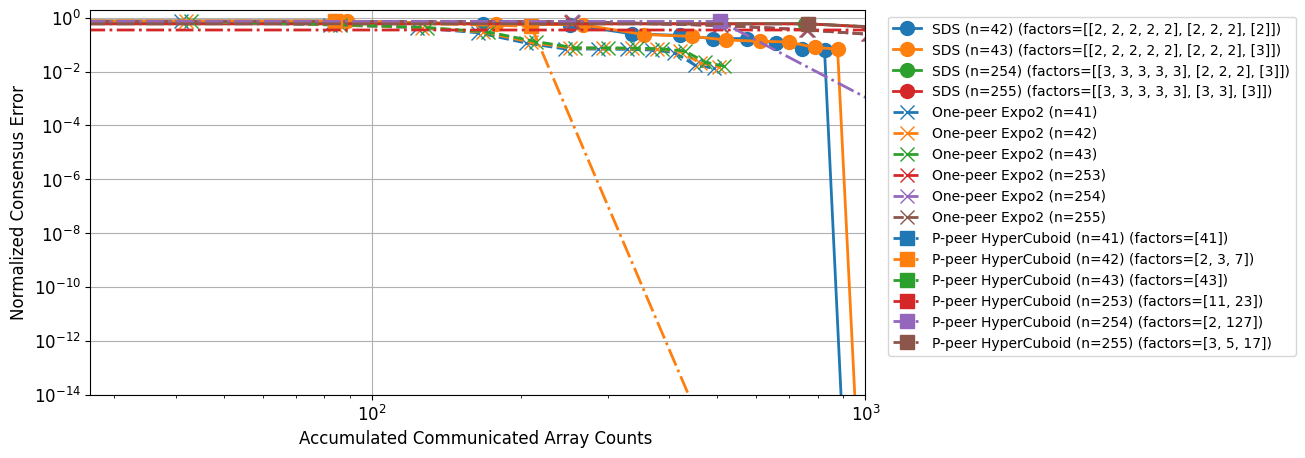

In [254]:
plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 
plt.rc('legend', fontsize=10)
# DSHB
plot_phase=True
for n_sub, n_sub_facts in generate_test_case():
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    for sub, sub_facts in zip(n_sub, n_sub_facts):
        assert sub == np.prod(sub_facts)
    
    consensus_error, accum_degree = get_mse_dshb(n_sub, n_sub_facts)
    plt.loglog(accum_degree, consensus_error, label=f"SDS ({n=}) (factors={n_sub_facts})", marker="o", linewidth=2, markersize=10)

# Dyn_exp2
for i, n in enumerate([41, 42, 43, 253, 254, 255]):
    consensus_error, accum_degree = get_mse_exp(n, iters=12)
    plt.loglog(accum_degree, consensus_error, '--', label=f"One-peer Expo2 ({n=})", marker="x", linewidth=2, markersize=10,
                color=f"C{i}")


for i, (n, factors) in enumerate([
        (41, [41]),
        (42, [2, 3, 7]), 
        (43, [43]),
        (253, [11, 23]), 
        (254, [2, 127]), 
        (255, [3, 5, 17])
    ]):
    consensus_error, accum_degree = get_mes_hypercuboid(n, factors=factors, iters=12)
    plt.loglog(accum_degree, consensus_error, '-.', label=f"P-peer HyperCuboid ({n=}) ({factors=})", marker="s", linewidth=2, markersize=10,
                 color=f"C{i}")

plt.xlim(0, 1e3)
plt.ylim(1e-14, 2e0)
plt.xlabel("Accumulated Communicated Array Counts ")
plt.ylabel("Normalized Consensus Error")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig('consensus_by_comm.pdf',  format="pdf")
plt.show()

# DSHB + LR

In [9]:
def gradient_tracking(graph_generator, eta = 0.0002, alpha = 1, max_iters = 1000, reg = 0, noise=False):
  mse = []

  x_prev = np.zeros((dimension, num_workers))
  x_curr = np.zeros((dimension, num_workers))
  g_curr = np.zeros((dimension, num_workers))
  for a in range(num_workers):
    g_curr[:, [a]] = alpha * lr.grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)

  for ite in notebook.tqdm(range(max_iters)):
    mse.append(np.linalg.norm(x_curr-x_opt)/np.linalg.norm(x_opt))
    W = graph_generator(ite)

    for a in range(num_workers):
      x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
    x_curr = x_curr @ W.T

    g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
    for a in range(num_workers):
        y_curr = lr.grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = lr.grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

    x_prev = x_curr.copy()
  return mse

In [10]:
def dgd(graph_generator, eta = 0.0002, alpha = 1, max_iters = 1000, reg = 0, noise=False):
  mse = []

  x_curr = np.zeros((dimension, num_workers))
  for ite in notebook.tqdm(range(max_iters)):
    mse.append(np.linalg.norm(x_curr-x_opt)/np.linalg.norm(x_opt))
    W = graph_generator(ite)

    for a in range(num_workers):
      g_curr = lr.grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
      x_curr[:, [a]] = x_curr[:, [a]] - eta *  g_curr
    x_curr = x_curr @ W.T

  return mse

In [35]:
dimension = 50
num_workers = 81*3 + 27# 253
num_data = num_workers * 100
noise_level = 0.1
As, bs, x_opt = lr.generate_linear_regression_data(
    num_data, dimension, num_workers, noise_level
)
 

In [56]:
USE_DGD = True
eta = 0.001
max_iters=500

In [84]:
importlib.reload(topo)

<module 'topology' from '/Users/ybc/Documents/github/tv-alg/topology.py'>

In [62]:
graph_generator = functools.partial(topo.dynamic_exp2, size=num_workers)
mse = dgd(graph_generator, eta=eta, max_iters=max_iters) if USE_DGD else gradient_tracking(graph_generator, eta=eta, max_iters=max_iters)

  0%|          | 0/500 [00:00<?, ?it/s]

In [72]:
graph_generator = functools.partial(topo.ring, size=num_workers)
mse3 = dgd(graph_generator, eta=eta, max_iters=max_iters) if USE_DGD else gradient_tracking(graph_generator, eta=eta, max_iters=max_iters)

  0%|          | 0/500 [00:00<?, ?it/s]

In [85]:
graph_generator = functools.partial(topo.star, size=num_workers)
mse4 = dgd(graph_generator, eta=eta, max_iters=max_iters) if USE_DGD else gradient_tracking(graph_generator, eta=eta, max_iters=max_iters)

  0%|          | 0/500 [00:00<?, ?it/s]

In [103]:
import equi_topo
m = int(np.log2(num_workers))
Ms = [2**i for i in range(20) if 2**i < num_workers]

def graph_generator(ite):
    return equi_topo.ODEquiDyn(num_workers, Ms=Ms)

mse5 = dgd(graph_generator, eta=eta, max_iters=max_iters) if USE_DGD else gradient_tracking(graph_generator, eta=eta, max_iters=max_iters)

def graph_generator(ite):
    return equi_topo.OUEquiDyn(num_workers, Ms=Ms)

mse6 = dgd(graph_generator, eta=eta, max_iters=max_iters) if USE_DGD else gradient_tracking(graph_generator, eta=eta, max_iters=max_iters)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [63]:
n_sub = [81*3, 27]
n_sub_facts = [[3, 3, 3, 3, 3], [3, 3, 3]]
assert sum(n_sub) == num_workers
full_list = sf.get_all_sds_matrices(n_sub, n_sub_facts)

def graph_generator2(ite):
    N = len(full_list)
    return full_list[ite % N]

mse2 = dgd(graph_generator2, eta=eta, max_iters=max_iters) if USE_DGD else gradient_tracking(graph_generator2, eta=eta, max_iters=max_iters)

  0%|          | 0/500 [00:00<?, ?it/s]

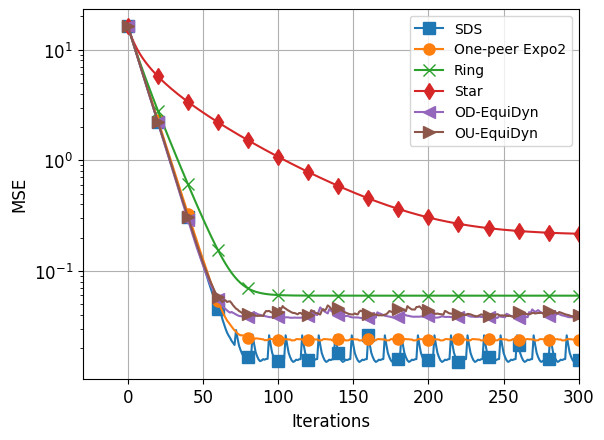

In [116]:
plt.semilogy(mse2, "-s", label="SDS", markevery=20, markersize=8)
plt.semilogy(mse, "-o", label="One-peer Expo2", markevery=20, markersize=8)
plt.semilogy(mse3, "-x", label="Ring", markevery=20, markersize=8)
plt.semilogy(mse4, "-d", label="Star", markevery=20, markersize=8)
plt.semilogy(mse5, "-<", label="OD-EquiDyn", markevery=20, markersize=8)
plt.semilogy(mse6, "->", label="OU-EquiDyn", markevery=20, markersize=8)


plt.legend()
plt.xlim([-30, 300])
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.savefig('lr_experiment.pdf',  format="pdf")
plt.show()


In [171]:
from importlib import reload
reload(sf)

<module 'sparse_factorization' from '/Users/ybc/Documents/github/tv-alg/sparse_factorization.py'>

In [172]:
J_0_list = sf.sds_phase1_or_3(n_sub=[10, 3, 2], n_sub_facts=[[10], [3], [2]])

In [173]:
J_0 = J_0_list[0]
M = sf.rhb_phase_2([10, 3, 2])
J_0 @ M @ J_0 * 15

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.